# Quality Control and Preprocessing of Heart snRNA-seq Data

## Overview

This notebook implements quality control (QC) and preprocessing for single-nucleus RNA-sequencing (snRNA-seq) data from human heart tissue, obtained from the [HuBMAP Data Portal](https://data-products.hubmapconsortium.org/data_products/b4116f8c-27da-4dd6-af69-c2b323b8db5c/).

## Dataset Characteristics

- **Tissue**: Human heart (multiple donors)
- **Technology**: 10x Genomics single-nucleus RNA-seq
- **Source**: HuBMAP Consortium
- **Data Product ID**: b4116f8c-27da-4dd6-af69-c2b323b8db5c

## QC Strategy

We follow best practices from:
- Luecken & Theis (2019). *Current best practices in single-cell RNA-seq analysis.*
- Heumos et al. (2023). *Best practices for single-cell analysis across modalities.*

### Key QC Metrics

1. **Genes detected per nucleus**: Filter low-quality cells and doublets
2. **Total UMI counts**: Assess sequencing depth and technical quality
3. **Mitochondrial content**: Remove damaged/dying cells (high MT% indicates compromised membrane integrity)

### Processing Steps

1. **Load raw data** and compute QC metrics
2. **Apply cell-level filters** (genes detected, MT%, doublets)
3. **Apply gene-level filters** (expressed in ≥3 cells)
4. **Normalize** (library size normalization to 10,000 counts per cell)
5. **Transform** (log₁(x+1) for variance stabilization)
6. **Save** processed data for downstream analysis

## Outputs

1. **Primary**: `data/raw/HT_raw_processed.h5ad` — QC-filtered, normalized data
2. **Logs**: `outputs/logs/qc_summary.txt` — Full QC report with statistics
3. **Tables**: `outputs/tables/donor_counts.csv` — Donor-level cell counts
4. **Figures**: 5 supplemental QC figures (S1-S5) in `outputs/figures_v1/`

In [1]:
import hashlib
from datetime import datetime
from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix, issparse

## Setup

### Library Dependencies

In [2]:
# Load the AnnData object
H5AD = Path("data/raw/HT_raw.h5ad")

if H5AD.exists():
    print("Loading single-nucleus RNA-seq data...")
    adata = ad.read_h5ad(H5AD)

    print(f"Observations (cells/nuclei): {adata.n_obs:,}")
    print(f"Variables (genes): {adata.n_vars:,}")
    print(f"Data matrix type: {type(adata.X).__name__}")
    print(f"Observation metadata: {', '.join(adata.obs.columns.tolist())}")
    
    print(f"Sample preview (first 5 nuclei)")
    print(adata.obs.head())
else:
    raise FileNotFoundError(f"Dataset not found at {H5AD}")

Loading single-nucleus RNA-seq data...
Observations (cells/nuclei): 675,772
Variables (genes): 60,286
Data matrix type: csr_matrix
Observation metadata: uuid, hubmap_id, age, sex, height, weight, bmi, cause_of_death, race, barcode, dataset, azimuth_label, azimuth_id, predicted_CLID, predicted_label, cl_match_type, prediction_score
Sample preview (first 5 nuclei)
                                                                                uuid  \
cell_id                                                                                
17f67cb15e59f65e640d85d2f3866cde-AACGCGCAGAAAGC...  17f67cb15e59f65e640d85d2f3866cde   
17f67cb15e59f65e640d85d2f3866cde-AACGCGCAGAAAGC...  17f67cb15e59f65e640d85d2f3866cde   
17f67cb15e59f65e640d85d2f3866cde-AACGCGCAGAAAGC...  17f67cb15e59f65e640d85d2f3866cde   
17f67cb15e59f65e640d85d2f3866cde-AACGCGCAGAAAGC...  17f67cb15e59f65e640d85d2f3866cde   
17f67cb15e59f65e640d85d2f3866cde-AACGCGCAGAAAGC...  17f67cb15e59f65e640d85d2f3866cde   

                  

### Load Raw Data

**Input**: `data/raw/HT_raw.h5ad` — Raw count matrix from HuBMAP

This file contains:
- **Observations**: Individual nuclei (rows)
- **Variables**: Genes (columns)
- **Matrix**: Raw UMI counts (sparse format for memory efficiency)
- **Metadata**: Donor IDs, batch information, pre-computed annotations

In [3]:
print("Computing dataset provenance metadata...")

# Compute file metadata
file_size = H5AD.stat().st_size
file_size_mb = file_size / (1024 * 1024)
file_size_gb = file_size_mb / 1024

# Compute MD5 hash for reproducibility
print("  → Generating MD5 checksum...")
md5_hash = hashlib.md5()
with open(H5AD, "rb") as f:
    for chunk in iter(lambda: f.read(8192), b""):
        md5_hash.update(chunk)

metadata = {
    "dataset_name": "HT_raw.h5ad",
    "source": "HuBMAP Data Portal",
    "data_product_id": "b4116f8c-27da-4dd6-af69-c2b323b8db5c",
    "url": "https://data-products.hubmapconsortium.org/data_products/b4116f8c-27da-4dd6-af69-c2b323b8db5c/",
    "file_path": str(H5AD),
    "file_size": f"{file_size_gb:.2f} GB ({file_size_mb:.1f} MB)",
    "md5_checksum": md5_hash.hexdigest(),
    "analysis_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "n_nuclei": adata.n_obs,
    "n_genes": adata.n_vars,
}

for k, v in metadata.items():
    print(f"{k.replace('_', ' ').title():.<30} {v}")

Computing dataset provenance metadata...
  → Generating MD5 checksum...
Dataset Name.................. HT_raw.h5ad
Source........................ HuBMAP Data Portal
Data Product Id............... b4116f8c-27da-4dd6-af69-c2b323b8db5c
Url........................... https://data-products.hubmapconsortium.org/data_products/b4116f8c-27da-4dd6-af69-c2b323b8db5c/
File Path..................... data/raw/HT_raw.h5ad
File Size..................... 0.33 GB (339.2 MB)
Md5 Checksum.................. eaeae5cd410eaf11cc2cc86e57e1906e
Analysis Date................. 2026-02-07 16:24:15
N Nuclei...................... 675772
N Genes....................... 60286


### Dataset Provenance

**Reproducibility**: Record file metadata for exact dataset identification.

- **MD5 checksum**: Cryptographic hash ensures file integrity
- **File size**: Helps verify complete downloads
- **Analysis timestamp**: Track when QC was performed

In [4]:
print("Analyzing donor/sample structure...")

# Identify donor identifier columns
donor_cols = [
    col
    for col in adata.obs.columns
    if any(x in col.lower() for x in ["donor", "sample", "batch", "hubmap"])
]

print(f"Total nuclei profiled: {adata.n_obs:,}")
print(
    f"Donor identifier columns found: {', '.join(donor_cols) if donor_cols else 'None'}"
)

# Use hubmap_id as primary donor identifier
if "hubmap_id" in adata.obs.columns:
    donor_col = "hubmap_id"
    print(f"\nUsing '{donor_col}' for donor stratification")

    # Count cells per donor
    donor_counts = adata.obs[donor_col].value_counts().sort_index()
    n_donors = len(donor_counts)
    min_cells = donor_counts.min()
    max_cells = donor_counts.max()
    mean_cells = donor_counts.mean()

    print(f"Number of unique donors: {n_donors}")
    print(f"Nuclei per donor (min): {min_cells:,}")
    print(f"Nuclei per donor (max): {max_cells:,}")
    print(f"Nuclei per donor (mean): {mean_cells:,.0f}")
    print(f"Nuclei per donor (median): {donor_counts.median():,.0f}")

    for donor_id, count in donor_counts.items():
        print(f"{donor_id}: {count:,} nuclei ({100*count/adata.n_obs:.1f}%)")

    if n_donors >= 2:
        print(
            f"✓ Multiple donors detected (n={n_donors}) - sufficient for batch analysis"
        )
    else:
        print(f"⚠ Single donor dataset - batch correction not applicable")

    if min_cells >= 200:
        print(f"✓ All donors have adequate cell counts (min: {min_cells:,})")
    else:
        print(
            f"⚠ Some donors have <200 nuclei (min: {min_cells:,}) - may affect statistical power"
        )
else:
    print("\n⚠ Warning: No HuBMAP donor identifier found in metadata")
    print("   Cannot perform donor-level stratification")

Analyzing donor/sample structure...
Total nuclei profiled: 675,772
Donor identifier columns found: hubmap_id

Using 'hubmap_id' for donor stratification
Number of unique donors: 15
Nuclei per donor (min): 736
Nuclei per donor (max): 65,248
Nuclei per donor (mean): 45,051
Nuclei per donor (median): 52,534
HBM236.JPVT.769: 14,298 nuclei (2.1%)
HBM296.KZXD.676: 52,534 nuclei (7.8%)
HBM342.CMHT.948: 49,719 nuclei (7.4%)
HBM364.XLVH.839: 53,149 nuclei (7.9%)
HBM385.LQVK.975: 55,605 nuclei (8.2%)
HBM537.MVDQ.934: 3,228 nuclei (0.5%)
HBM563.ZTQV.233: 63,137 nuclei (9.3%)
HBM573.MWDW.928: 49,449 nuclei (7.3%)
HBM592.DXHG.266: 60,348 nuclei (8.9%)
HBM599.GNJN.777: 50,704 nuclei (7.5%)
HBM852.VXGN.375: 53,121 nuclei (7.9%)
HBM927.DZCV.762: 50,859 nuclei (7.5%)
HBM943.DFKN.947: 65,248 nuclei (9.7%)
HBM957.TXXZ.387: 736 nuclei (0.1%)
HBM982.THGM.772: 53,637 nuclei (7.9%)
✓ Multiple donors detected (n=15) - sufficient for batch analysis
✓ All donors have adequate cell counts (min: 736)


### Donor/Sample Structure

**Multi-donor datasets**: Essential for assessing batch effects and biological variability.

**Key Questions**:
- How many donors contributed data?
- Are cell counts balanced across donors?
- Do we have sufficient statistical power for donor-level comparisons?

**Minimum Requirements**:
- ≥2 donors for batch effect analysis
- ≥200 cells per donor for stable statistics
- Preferably balanced distribution to avoid donor-driven clustering

In [5]:
# Export donor statistics for downstream analysis
print("Exporting donor distribution table...")
Path("outputs/tables").mkdir(parents=True, exist_ok=True)

donor_counts_df = donor_counts.reset_index()
donor_counts_df.columns = ["donor_id", "n_cells"]
donor_counts_df.to_csv("outputs/tables/donor_counts.csv", index=False)

print(f"  → Saved to: outputs/tables/donor_counts.csv")
print(donor_counts_df["n_cells"].describe().to_string())

Exporting donor distribution table...
  → Saved to: outputs/tables/donor_counts.csv
count       15.000000
mean     45051.466667
std      20884.676508
min        736.000000
25%      49584.000000
50%      52534.000000
75%      54621.000000
max      65248.000000


### Export Donor Statistics

In [6]:
print("Computing quality control metrics...")

# Calculate total UMI counts per nucleus
print("  → Computing total UMI counts per nucleus...")
adata.obs["total_counts"] = np.array(adata.X.sum(axis=1)).flatten()

# Calculate number of genes detected per nucleus
print("  → Calculating genes detected per nucleus...")
adata.obs["n_genes"] = np.array((adata.X > 0).sum(axis=1)).flatten()

# Identify and quantify mitochondrial genes
print("  → Identifying mitochondrial genes (MT- prefix)...")
sym = adata.var["hugo_symbol"]
sym_str = sym.astype("string")
adata.var["mt"] = sym_str.str.upper().str.startswith("MT-").fillna(False)
n_mt_genes = adata.var["mt"].sum()

print(f"Mitochondrial genes detected: {n_mt_genes}")

# Compute mitochondrial percentage
if n_mt_genes > 0:
    mt_counts = np.array(adata[:, adata.var["mt"]].X.sum(axis=1)).flatten()
    adata.obs["pct_counts_mt"] = (mt_counts / adata.obs["total_counts"]) * 100
    print("  → Mitochondrial percentage calculated successfully")
else:
    adata.obs["pct_counts_mt"] = 0.0
    print("  ⚠ No mitochondrial genes found - using 0% for all nuclei")

# Display summary statistics
qc_stats = adata.obs[["total_counts", "n_genes", "pct_counts_mt"]].describe()
print(qc_stats.to_string())

Computing quality control metrics...
  → Computing total UMI counts per nucleus...
  → Calculating genes detected per nucleus...
  → Identifying mitochondrial genes (MT- prefix)...
Mitochondrial genes detected: 23
  → Mitochondrial percentage calculated successfully
        total_counts        n_genes  pct_counts_mt
count  675772.000000  675772.000000  461814.000000
mean       41.951183      34.175503       3.912095
std       284.046234     137.507045      13.594329
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         1.000000       1.000000       0.000000
75%         5.000000       7.000000       1.405738
max     26793.222656    5632.000000     100.000000


## Quality Control Metrics

### Compute Cell-Level QC Metrics

**Three core metrics** for single-nucleus RNA-seq:

1. **Total UMI counts** (`total_counts`): Sum of all UMIs per nucleus
   - *Low counts*: Poor capture efficiency, dead cells, empty droplets
   - *Very high counts*: Potential doublets (two cells in one droplet)

2. **Genes detected** (`n_genes`): Number of genes with ≥1 UMI
   - *Low genes*: Low-quality cells, ambient RNA contamination
   - *Very high genes*: Doublets, or genuinely complex cells

3. **Mitochondrial percentage** (`pct_counts_mt`): % of UMIs from mitochondrial genes
   - *High MT%*: Damaged cells (cytoplasm leaks, MT RNA enriched)
   - *Normal range*: Typically <5-20% depending on cell type and tissue

**MT gene identification**: Genes with HUGO symbols starting with "MT-" (human mitochondrial genome-encoded genes).

In [7]:
# Record pre-filtering dimensions
n_cells_before = adata.n_obs
n_genes_before = adata.n_vars

print(f"Initial dataset: {n_cells_before:,} nuclei × {n_genes_before:,} genes")

# Define biologically motivated filter thresholds
MIN_GENES = 200  # Minimum genes to consider nucleus viable
MAX_GENES = 6000  # Upper bound to exclude potential doublets
MAX_MT_PCT = 20  # Maximum mitochondrial content (high = damaged cells)

print(f"Minimum genes per nucleus: {MIN_GENES:,}")
print(f"  → Rationale: Exclude low-quality/empty droplets")
print(f"Maximum genes per nucleus: {MAX_GENES:,}")
print(f"  → Rationale: Exclude potential doublets/multiplets")
print(f"Maximum mitochondrial %: {MAX_MT_PCT}%")
print(f"  → Rationale: Exclude damaged/dying cells")

# Apply cell quality filters
cell_filter = (
    (adata.obs["n_genes"] >= MIN_GENES)
    & (adata.obs["n_genes"] <= MAX_GENES)
    & (adata.obs["pct_counts_mt"] <= MAX_MT_PCT)
)

n_passing = cell_filter.sum()
n_failing = n_cells_before - n_passing
pct_retained = 100 * n_passing / n_cells_before

print(f"Nuclei passing filters: {n_passing:,} ({pct_retained:.1f}%)")
print(f"Nuclei removed: {n_failing:,} ({100-pct_retained:.1f}%)")

# Apply the filter
print("\n  → Filtering nuclei...")
adata_filtered = adata[cell_filter, :].copy()

# Filter genes: keep only genes expressed in multiple cells
MIN_CELLS = 3
print(f"\n  → Filtering genes (min {MIN_CELLS} cells expressing)...")
gene_filter = np.array((adata_filtered.X > 0).sum(axis=0)).flatten() >= MIN_CELLS
adata_filtered = adata_filtered[:, gene_filter].copy()

n_cells_after = adata_filtered.n_obs
n_genes_after = adata_filtered.n_vars

print(f"Nuclei retained: {n_cells_after:,} ({100*n_cells_after/n_cells_before:.1f}%)")
print(f"Nuclei removed: {n_cells_before - n_cells_after:,}")
print(f"Genes retained: {n_genes_after:,} ({100*n_genes_after/n_genes_before:.1f}%)")
print(f"Genes removed: {n_genes_before - n_genes_after:,}")

Initial dataset: 675,772 nuclei × 60,286 genes
Minimum genes per nucleus: 200
  → Rationale: Exclude low-quality/empty droplets
Maximum genes per nucleus: 6,000
  → Rationale: Exclude potential doublets/multiplets
Maximum mitochondrial %: 20%
  → Rationale: Exclude damaged/dying cells
Nuclei passing filters: 23,279 (3.4%)
Nuclei removed: 652,493 (96.6%)

  → Filtering nuclei...

  → Filtering genes (min 3 cells expressing)...
Nuclei retained: 23,279 (3.4%)
Nuclei removed: 652,493
Genes retained: 29,072 (48.2%)
Genes removed: 31,214


### Apply Quality Filters

**Cell-level filters** (biologically motivated thresholds):

| Filter | Threshold | Rationale |
|--------|-----------|-----------|
| **Minimum genes** | 200 | Exclude empty droplets and debris |
| **Maximum genes** | 6000 | Remove potential doublets/multiplets |
| **Maximum MT%** | 20% | Remove damaged/dying cells |

**Gene-level filter**:
- **Minimum cells expressing**: 3 cells — Removes technical noise and rare artifacts

**Trade-offs**:
- *Too strict*: Loss of rare cell types
- *Too lenient*: Contamination from low-quality cells

**Best Practice**: Visual inspection of distributions (see Figures S2-S3) before finalizing thresholds.

In [8]:
# Preserve raw counts for future reference
print("  → Storing raw counts in 'counts' layer...")
adata_filtered.layers["counts"] = adata_filtered.X.copy()

# Library size normalization (counts per 10,000)
target_sum = 1e4
print(f"  → Normalizing to {target_sum:,.0f} counts per nucleus...")
print(f"     (Controls for sequencing depth differences)")

size_factors = np.array(adata_filtered.X.sum(axis=1)).flatten()
size_factors = size_factors / target_sum

if issparse(adata_filtered.X):
    X_norm = adata_filtered.X.copy()
    X_norm = X_norm.multiply(1 / size_factors[:, None])
    X_norm = csr_matrix(X_norm)  # Ensure CSR format for AnnData compatibility
else:
    X_norm = adata_filtered.X / size_factors[:, None]

# Log transformation: log(x + 1)
print(f"  → Applying log₁(x + 1) transformation...")
print(f"     (Stabilizes variance and approximates normality)")

if issparse(X_norm):
    X_norm.data = np.log1p(X_norm.data)
else:
    X_norm = np.log1p(X_norm)

adata_filtered.X = X_norm

# Verify data integrity
has_nan = np.isnan(
    adata_filtered.X.data if issparse(adata_filtered.X) else adata_filtered.X
).any()
has_inf = np.isinf(
    adata_filtered.X.data if issparse(adata_filtered.X) else adata_filtered.X
).any()

if not has_nan and not has_inf:
    print("✓ Data matrix is clean")
    print("  → No NaN values detected")
    print("  → No infinite values detected")
    print("  → Ready for downstream analysis")
else:
    if has_nan:
        print("⚠ Warning: NaN values detected in normalized matrix")
    if has_inf:
        print("⚠ Warning: Infinite values detected in normalized matrix")

  → Storing raw counts in 'counts' layer...
  → Normalizing to 10,000 counts per nucleus...
     (Controls for sequencing depth differences)
  → Applying log₁(x + 1) transformation...
     (Stabilizes variance and approximates normality)
✓ Data matrix is clean
  → No NaN values detected
  → No infinite values detected
  → Ready for downstream analysis


### Normalization and Transformation

**Why normalize?** Raw UMI counts are affected by:
- Sequencing depth (technical variation between cells)
- Library size (total mRNA captured per cell)

**Method: Library Size Normalization**
1. **Scale** each cell to 10,000 total counts (CP10K normalization)
   - Puts all cells on comparable scale
   - Preserves relative gene expression within each cell
2. **Log-transform**: log₁(x + 1)
   - Stabilizes variance (large counts less influential)
   - Approximates normal distribution (improves downstream statistics)
   - Pseudocount (+1) prevents log(0) = -∞

**Raw counts preserved**: Stored in `layers['counts']` for DE analysis (which requires raw counts).

**Data integrity checks**: Verify no NaN or Inf values after transformation.

In [9]:
print("Generating quality control summary report...")

# Create comprehensive QC summary
Path("outputs/logs").mkdir(parents=True, exist_ok=True)

qc_summary = f"""Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Dataset: HuBMAP Heart snRNA-seq (Data Product ID: b4116f8c-27da-4dd6-af69-c2b323b8db5c)
File: {H5AD}

Total nuclei profiled: {n_cells_before:,}
Total genes measured: {n_genes_before:,}
Data matrix format: Sparse (CSR)

Cell-level filters:
  • Minimum genes per nucleus: {MIN_GENES:,} (exclude empty droplets)
  • Maximum genes per nucleus: {MAX_GENES:,} (exclude doublets)
  • Maximum mitochondrial %: {MAX_MT_PCT}% (exclude damaged cells)

Gene-level filters:
  • Minimum cells expressing: {MIN_CELLS} (remove rare/noise genes)

Nuclei retained: {n_cells_after:,} ({100*n_cells_after/n_cells_before:.2f}%)
Nuclei removed: {n_cells_before - n_cells_after:,} ({100*(n_cells_before-n_cells_after)/n_cells_before:.2f}%)

Genes retained: {n_genes_after:,} ({100*n_genes_after/n_genes_before:.2f}%)
Genes removed: {n_genes_before - n_genes_after:,} ({100*(n_genes_before-n_genes_after)/n_genes_before:.2f}%)

Method: Library size normalization + log transformation
  1. Scale to {target_sum:.0f} counts per nucleus (depth normalization)
  2. Apply log₁(x + 1) transformation (variance stabilization)

Raw counts preserved in layer: 'counts'

NaN values: {'None detected' if not has_nan else 'PRESENT - requires attention'}
Infinite values: {'None detected' if not has_inf else 'PRESENT - requires attention'}
Status: {'✓ PASSED - Ready for analysis' if not (has_nan or has_inf) else '⚠ FAILED - Manual review needed'}

Number of unique donors: {len(donor_counts)}
Nuclei per donor (range): {donor_counts.min():,} - {donor_counts.max():,}
Nuclei per donor (mean): {donor_counts.mean():.0f}
Nuclei per donor (median): {donor_counts.median():.0f}

Total nuclei across all donors: {donor_counts.sum():,}

Recommended downstream analyses:
  1. Highly variable gene selection
  2. Principal component analysis (PCA)
  3. Batch effect evaluation and correction (if needed)
  4. UMAP/t-SNE dimensionality reduction
  5. Clustering and cell type annotation
  6. Differential expression analysis
"""

# Save to file
with open("outputs/logs/qc_summary.txt", "w") as f:
    f.write(qc_summary)

# Display summary
print(qc_summary)
print("\n✓ Quality control report saved to: outputs/logs/qc_summary.txt")

Generating quality control summary report...
Analysis Date: 2026-02-07 16:24:16
Dataset: HuBMAP Heart snRNA-seq (Data Product ID: b4116f8c-27da-4dd6-af69-c2b323b8db5c)
File: data/raw/HT_raw.h5ad

Total nuclei profiled: 675,772
Total genes measured: 60,286
Data matrix format: Sparse (CSR)

Cell-level filters:
  • Minimum genes per nucleus: 200 (exclude empty droplets)
  • Maximum genes per nucleus: 6,000 (exclude doublets)
  • Maximum mitochondrial %: 20% (exclude damaged cells)

Gene-level filters:
  • Minimum cells expressing: 3 (remove rare/noise genes)

Nuclei retained: 23,279 (3.44%)
Nuclei removed: 652,493 (96.56%)

Genes retained: 29,072 (48.22%)
Genes removed: 31,214 (51.78%)

Method: Library size normalization + log transformation
  1. Scale to 10000 counts per nucleus (depth normalization)
  2. Apply log₁(x + 1) transformation (variance stabilization)

Raw counts preserved in layer: 'counts'

NaN values: None detected
Infinite values: None detected
Status: ✓ PASSED - Ready for

### Generate QC Summary Report

Comprehensive report includes:
- Dataset provenance and metadata
- Filter thresholds and rationale
- Pre/post-QC cell and gene counts
- Donor-level statistics
- Data integrity checks
- Recommendations for downstream analysis

In [10]:
print("Saving processed AnnData object...")

output_path = 'data/raw/HT_raw_processed.h5ad'
adata_filtered.write_h5ad(output_path)

print(f"✓ Processed dataset saved to: {output_path}")
print(f"  → Nuclei: {adata_filtered.n_obs:,}")
print(f"  → Genes: {adata_filtered.n_vars:,}")
print(f"  → Layers: {list(adata_filtered.layers.keys())}")
print(f"  → File size: {Path(output_path).stat().st_size / (1024**2):.1f} MB")
print(f"\nDataset is ready for downstream analysis.")

Saving processed AnnData object...
✓ Processed dataset saved to: data/raw/HT_raw_processed.h5ad
  → Nuclei: 23,279
  → Genes: 29,072
  → Layers: ['counts']
  → File size: 199.1 MB

Dataset is ready for downstream analysis.


### Save Processed Dataset

**Output**: `data/raw/HT_raw_processed.h5ad` contains:
- Filtered cell × gene matrix (normalized, log-transformed)
- Raw counts in `layers['counts']`
- QC metrics in `obs` (per-cell metadata)
- Gene annotations in `var` (including MT flags)

**Filename note**: Kept in `data/raw/` to indicate this is still "raw" in the sense of no dimensionality reduction or clustering. The next notebook ([HT_raw_processed.ipynb](HT_raw_processed.ipynb)) will add PCA/UMAP.

## Supplemental QC Figures

Generate 5 figures to visualize QC decisions and outcomes:

| Figure | Content | Purpose |
|--------|---------|---------|
| **S1** | Cell yield by donor (pre- vs post-QC) | Check retention rates per donor |
| **S2** | QC metric distributions by donor | Visualize pre/post-filtering distributions |
| **S3** | QC threshold visualization | Show cells removed by each filter |
| **S4** | Cell type composition shift | Assess if QC biases cell type proportions |
| **S5** | Mitochondrial gene signature | Examine MT gene expression patterns |

### Plotting Configuration

In [11]:
# Set publication-quality plotting parameters
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.size"] = 10
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.linewidth"] = 1.0
plt.rcParams["xtick.major.width"] = 1.0
plt.rcParams["ytick.major.width"] = 1.0

# Create figures output directory
figures_dir = Path("outputs/figures_v1")
figures_dir.mkdir(parents=True, exist_ok=True)

print("Matplotlib configuration set for publication-quality figures")
print(f"Figures will be saved to: {figures_dir}")

Matplotlib configuration set for publication-quality figures
Figures will be saved to: outputs/figures_v1


### Figure S1: Cell Yield by Donor

**Panel A**: Total nuclei profiled per donor before QC
- Shows raw data collection balance

**Panel B**: Retention rates per donor (pre vs post-QC)
- Check if QC disproportionately affects specific donors
- **Red labels**: Percentage retained
- **Expected**: 60-90% retention is typical for good-quality data

**Interpretation**: 
- Uniform retention across donors = good (no donor-specific quality issues)
- One donor with low retention = potential technical problem for that sample

✓ Figure S1 saved: Cell yield by donor


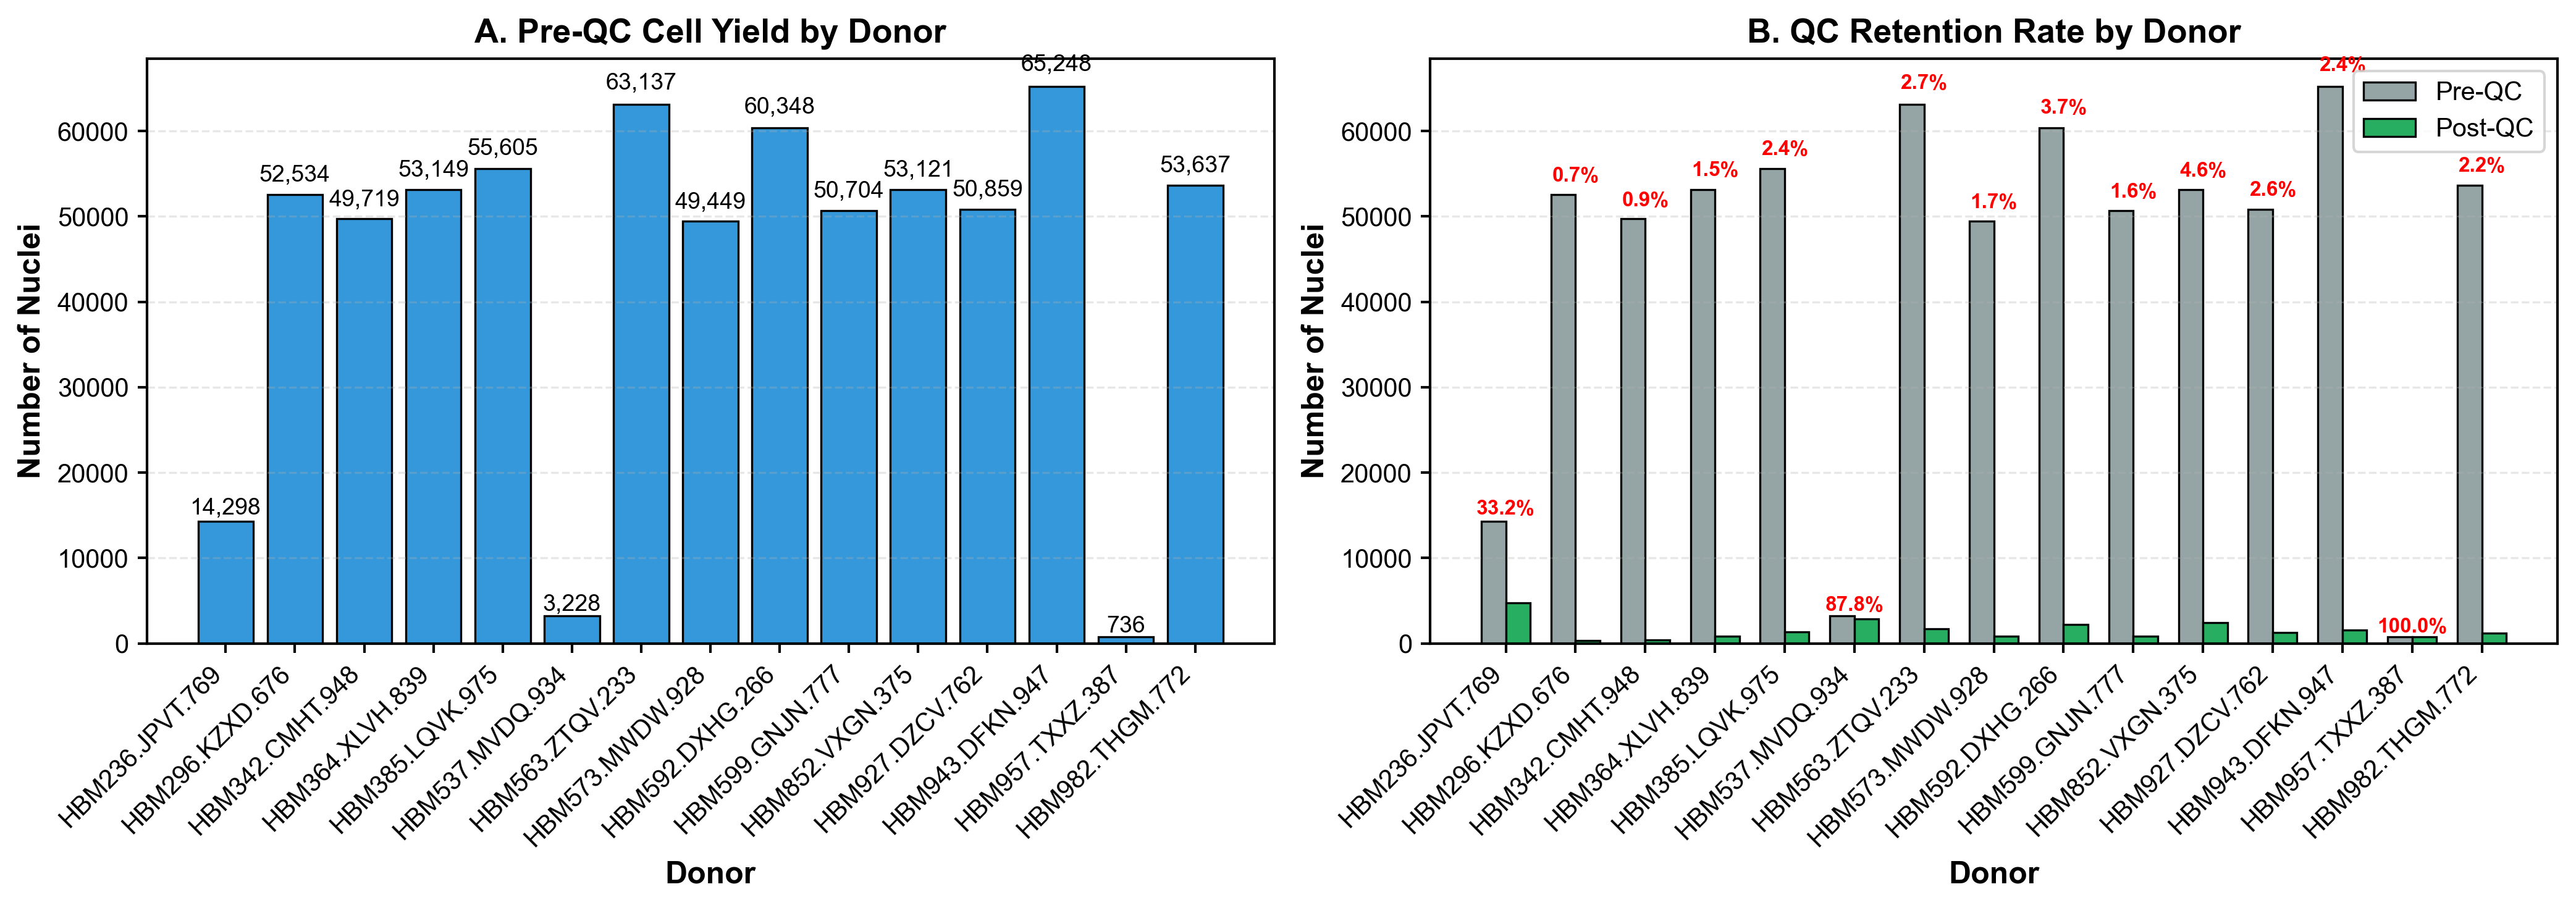

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Nuclei per donor (pre-QC)
donor_counts_before = adata.obs["hubmap_id"].value_counts().sort_index()
colors_before = ["#3498db"] * len(donor_counts_before)

ax1.bar(
    range(len(donor_counts_before)),
    donor_counts_before.values,
    color=colors_before,
    edgecolor="black",
    linewidth=0.8,
)
ax1.set_xlabel("Donor", fontsize=12, fontweight="bold")
ax1.set_ylabel("Number of Nuclei", fontsize=12, fontweight="bold")
ax1.set_title("A. Pre-QC Cell Yield by Donor", fontsize=13, fontweight="bold")
ax1.set_xticks(range(len(donor_counts_before)))
ax1.set_xticklabels(donor_counts_before.index, rotation=45, ha="right")
ax1.grid(axis="y", alpha=0.3, linestyle="--")

# Add value labels on bars
for i, v in enumerate(donor_counts_before.values):
    ax1.text(i, v + 0.02 * v, f"{v:,}", ha="center", va="bottom", fontsize=9)

# Panel B: Nuclei per donor with QC retention rate
donor_counts_after = adata_filtered.obs["hubmap_id"].value_counts().sort_index()
retention_rate = (donor_counts_after / donor_counts_before * 100).fillna(0)

# Create bars
x = np.arange(len(donor_counts_before))
width = 0.35

bars1 = ax2.bar(
    x - width / 2,
    donor_counts_before.values,
    width,
    label="Pre-QC",
    color="#95a5a6",
    edgecolor="black",
    linewidth=0.8,
)
bars2 = ax2.bar(
    x + width / 2,
    donor_counts_after.values,
    width,
    label="Post-QC",
    color="#27ae60",
    edgecolor="black",
    linewidth=0.8,
)

ax2.set_xlabel("Donor", fontsize=12, fontweight="bold")
ax2.set_ylabel("Number of Nuclei", fontsize=12, fontweight="bold")
ax2.set_title("B. QC Retention Rate by Donor", fontsize=13, fontweight="bold")
ax2.set_xticks(x)
ax2.set_xticklabels(donor_counts_before.index, rotation=45, ha="right")
ax2.legend(frameon=True, loc="upper right")
ax2.grid(axis="y", alpha=0.3, linestyle="--")

# Add retention percentage labels
for i, rate in enumerate(retention_rate.values):
    y_pos = max(donor_counts_before.values[i], donor_counts_after.values[i])
    ax2.text(
        i,
        y_pos + 0.02 * y_pos,
        f"{rate:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8,
        color="red",
        fontweight="bold",
    )

plt.tight_layout()
plt.savefig(figures_dir / "S1_cell_yield_by_donor.png", bbox_inches="tight")
plt.savefig(figures_dir / "S1_cell_yield_by_donor.pdf", bbox_inches="tight")
print("✓ Figure S1 saved: Cell yield by donor")
plt.show()

### Figure S2: QC Metric Distributions by Donor

**Three panels** comparing pre-QC (red) vs post-QC (green) distributions:

**Panel A** (Genes detected): Should show removal of low-count tail
**Panel B** (Total UMI counts): Should show removal of outliers at both ends  
**Panel C** (Mitochondrial %): Should show removal of high-MT cells above threshold

**Violin plots**: Show full distribution shape (better than box plots for multimodal data)

**What to look for**:
- Post-QC distributions should be tighter and more uniform
- Donor-to-donor variation should decrease after QC
- No single donor should drive the entire post-QC distribution

✓ Figure S2 saved: QC metric distributions by donor


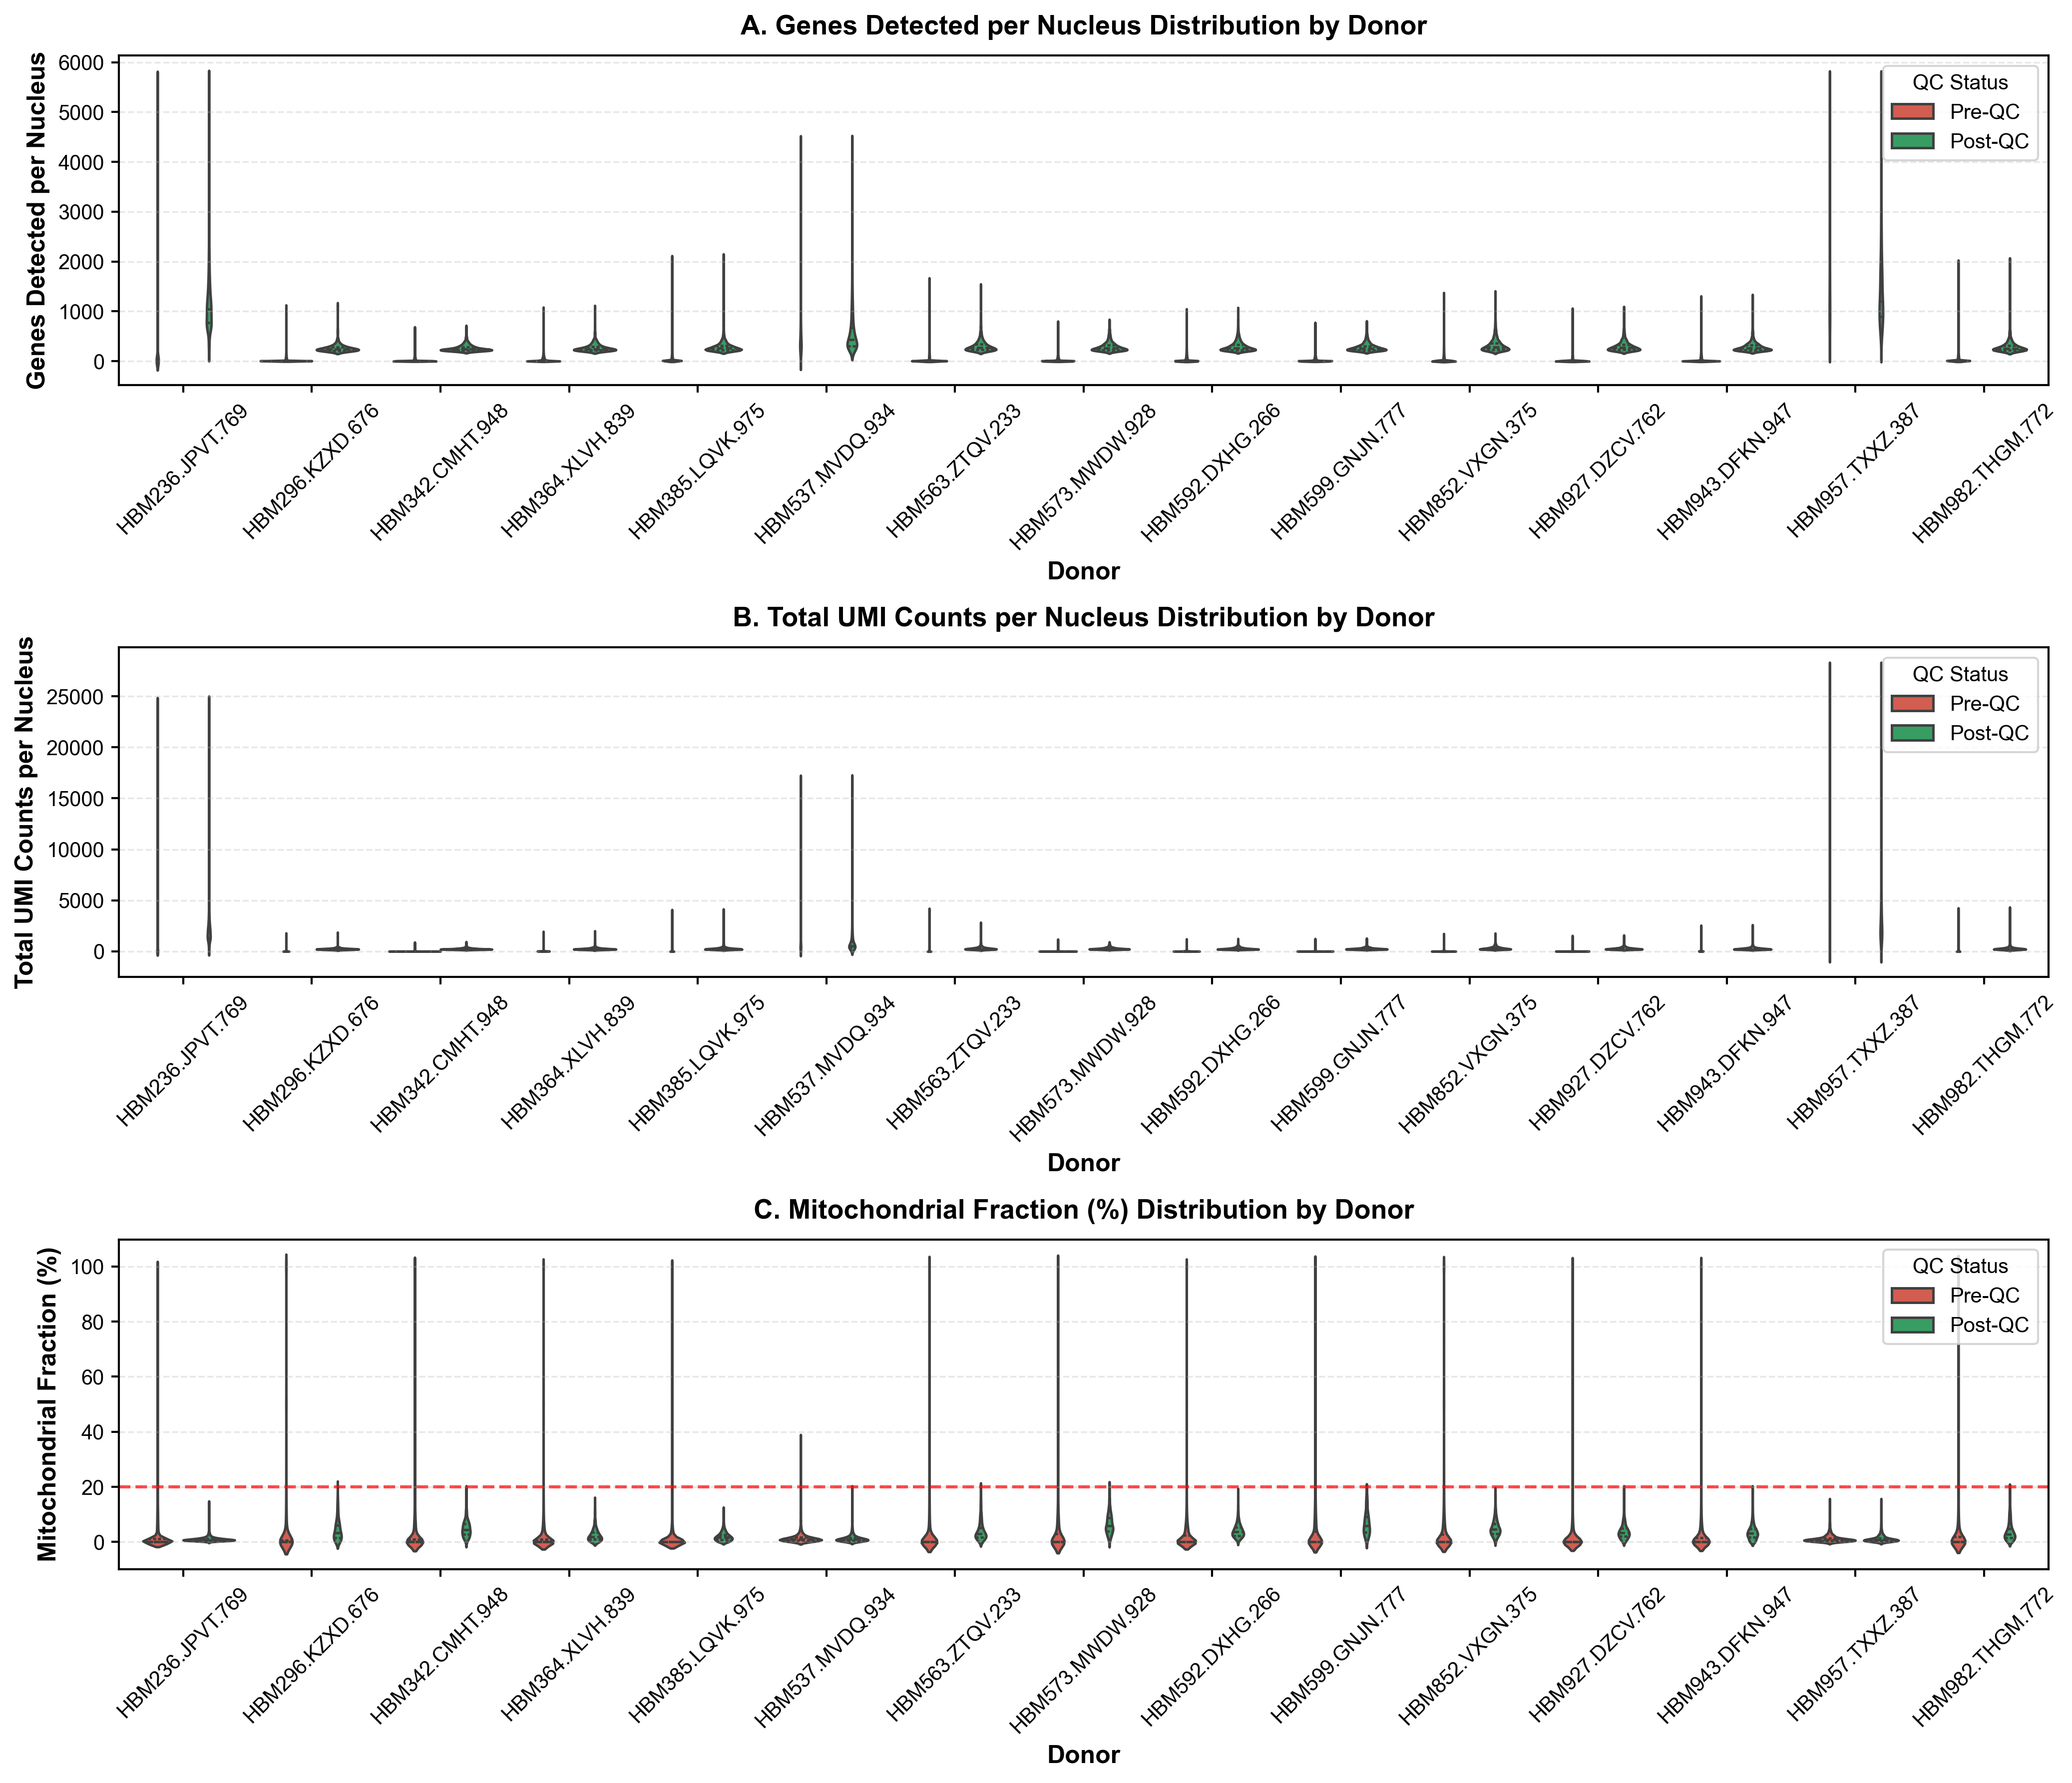

In [13]:
# Prepare data for pre/post comparison
adata_before = adata.copy()
adata_before.obs['QC_status'] = 'Pre-QC'
adata_after = adata_filtered.copy()
adata_after.obs['QC_status'] = 'Post-QC'

combined_df = pd.concat([
    adata_before.obs[['hubmap_id', 'n_genes', 'total_counts', 'pct_counts_mt', 'QC_status']].reset_index(drop=True),
    adata_after.obs[['hubmap_id', 'n_genes', 'total_counts', 'pct_counts_mt', 'QC_status']].reset_index(drop=True)
], ignore_index=True)

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

metrics = [
    ('n_genes', 'Genes Detected per Nucleus', 'A'),
    ('total_counts', 'Total UMI Counts per Nucleus', 'B'),
    ('pct_counts_mt', 'Mitochondrial Fraction (%)', 'C')
]

for ax, (metric, ylabel, panel) in zip(axes, metrics):
    sns.violinplot(data=combined_df, x='hubmap_id', y=metric, hue='QC_status',
                   split=False, palette={'Pre-QC': '#e74c3c', 'Post-QC': '#27ae60'},
                   ax=ax, inner='quartile', linewidth=1.2)
    
    ax.set_xlabel('Donor', fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    ax.set_title(f'{panel}. {ylabel} Distribution by Donor', 
                 fontsize=13, fontweight='bold', pad=10)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='QC Status', frameon=True, loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add median lines for reference
    if metric == 'pct_counts_mt':
        ax.axhline(y=MAX_MT_PCT, color='red', linestyle='--', 
                   linewidth=1.5, alpha=0.7, label=f'QC threshold ({MAX_MT_PCT}%)')

plt.tight_layout()
plt.savefig(figures_dir / 'S2_qc_distributions_by_donor.png', bbox_inches='tight')
plt.savefig(figures_dir / 'S2_qc_distributions_by_donor.pdf', bbox_inches='tight')
print("✓ Figure S2 saved: QC metric distributions by donor")
plt.show()

### Figure S3: QC Threshold Visualization

**Purpose**: Show precisely which cells are removed by each filter.

**Panel A** (Total counts vs Genes detected):
- **Green**: Cells passing QC
- **Red**: Cells removed
- **Horizontal lines**: Min/max gene thresholds
- Most removed cells should cluster in low-count/low-gene region

**Panel B** (Mitochondrial % vs Genes detected):
- **Vertical line**: MT% threshold (20%)
- Shows cells removed due to high mitochondrial content
- **Good pattern**: Red cells mostly in high-MT region

**Subsampling note**: 50,000 cells shown for visualization speed. Full filtering uses all cells.

**Interpretation**: Filters should create clean separation between kept/removed populations.

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


✓ Figure S3 saved: QC threshold visualization
  Note: Subsampled 50,000 of 675,772 nuclei for visualization


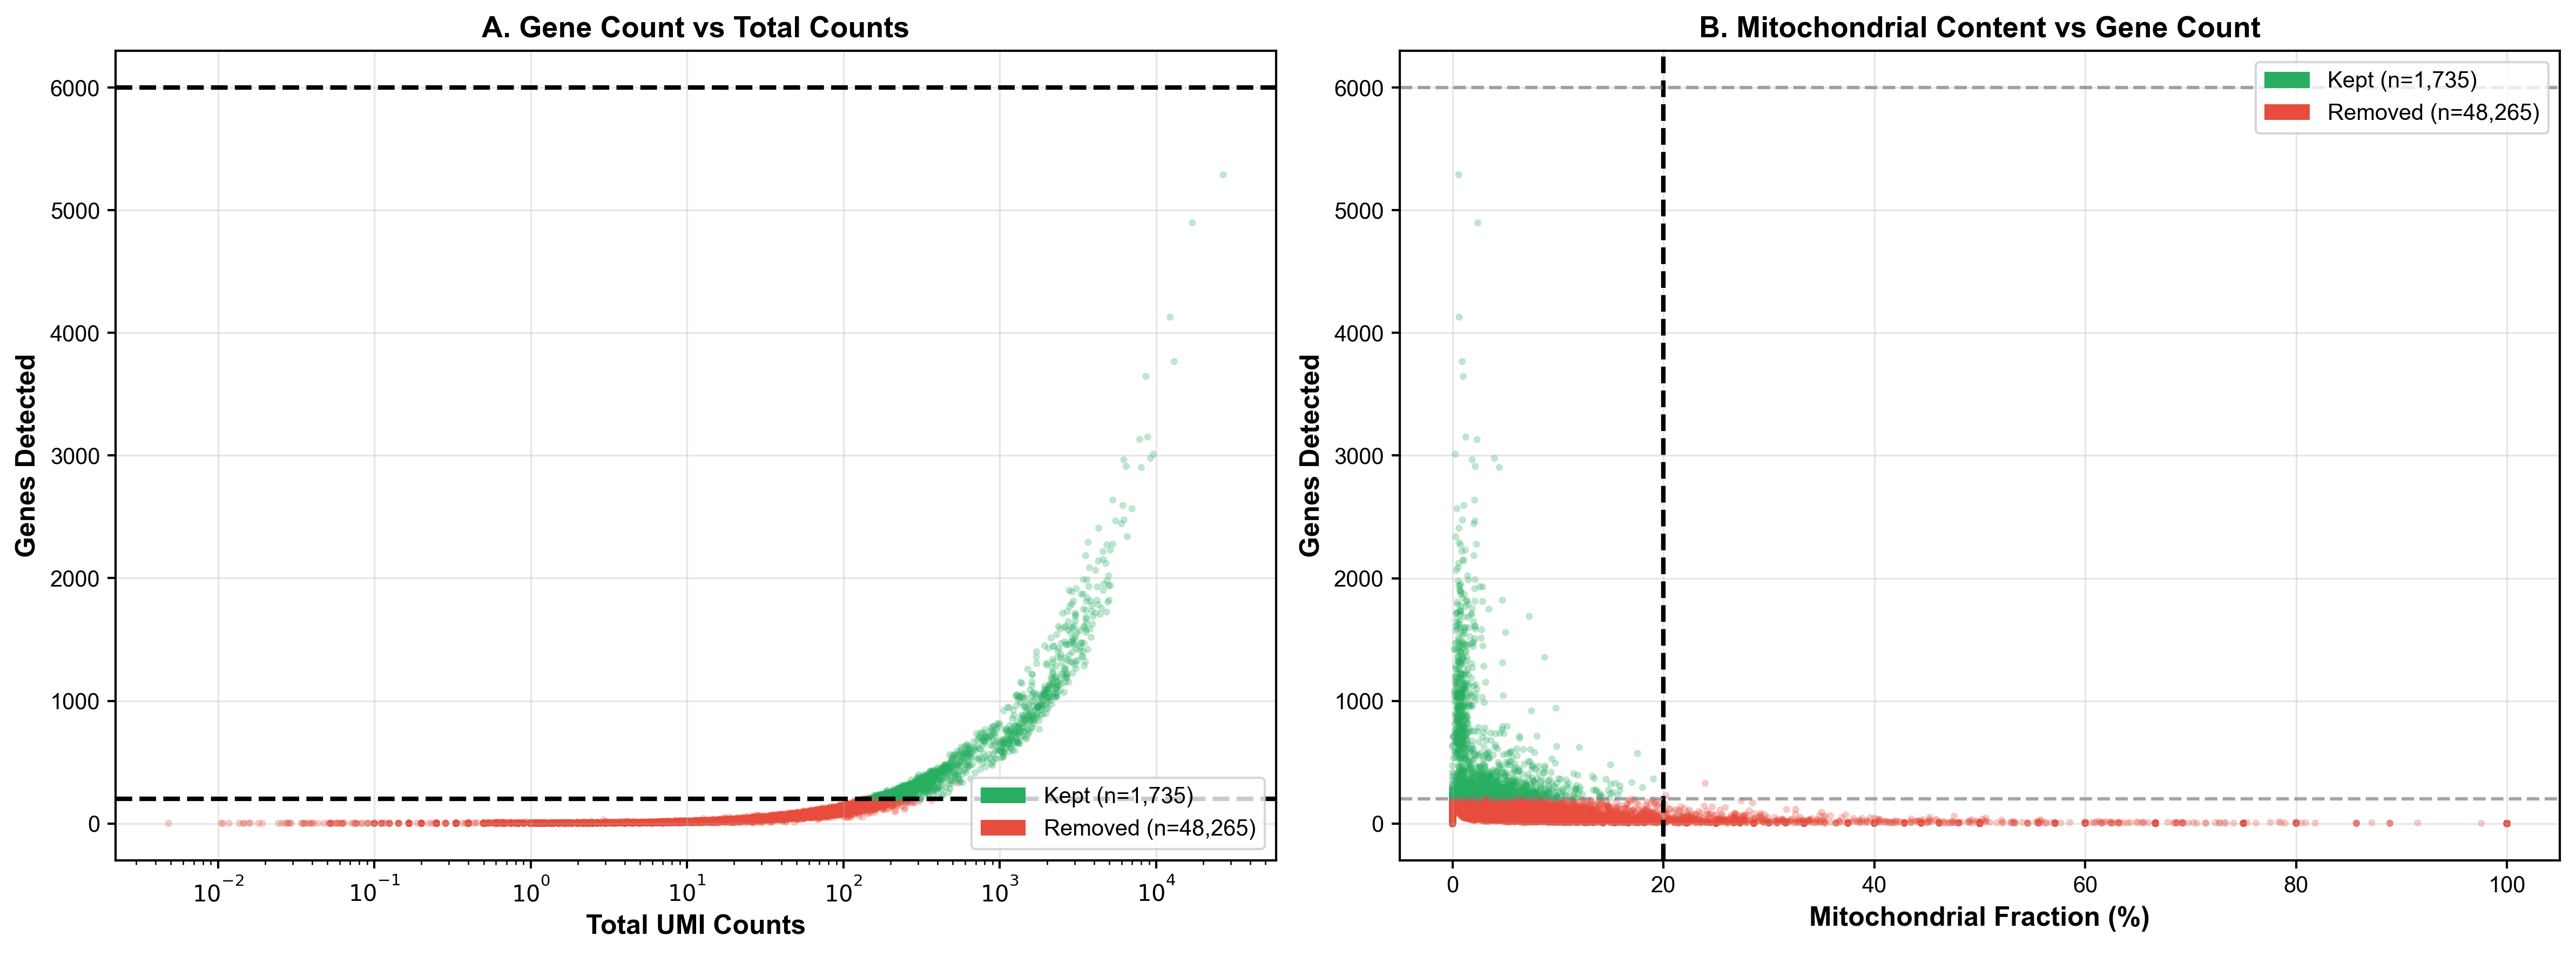

In [14]:
# Determine which cells passed QC
adata_before.obs["passed_qc"] = adata_before.obs.index.isin(adata_filtered.obs.index)

# Subsample for visualization (too many points slow down rendering)
np.random.seed(42)
n_subsample = min(50000, len(adata_before))
subsample_idx = np.random.choice(adata_before.n_obs, n_subsample, replace=False)
plot_data = adata_before.obs.iloc[subsample_idx].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Total counts vs Genes detected
ax1 = axes[0]
scatter1 = ax1.scatter(
    plot_data["total_counts"],
    plot_data["n_genes"],
    c=plot_data["passed_qc"].map({True: "#27ae60", False: "#e74c3c"}),
    alpha=0.3,
    s=10,
    edgecolors="none",
)

# Add threshold lines
ax1.axhline(
    y=MIN_GENES,
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"Min genes = {MIN_GENES}",
)
ax1.axhline(
    y=MAX_GENES,
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"Max genes = {MAX_GENES}",
)

ax1.set_xlabel("Total UMI Counts", fontsize=12, fontweight="bold")
ax1.set_ylabel("Genes Detected", fontsize=12, fontweight="bold")
ax1.set_title("A. Gene Count vs Total Counts", fontsize=13, fontweight="bold")
ax1.set_xscale("log")
ax1.legend(frameon=True)
ax1.grid(True, alpha=0.3)

# Add custom legend for kept/removed
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="#27ae60", label=f'Kept (n={plot_data["passed_qc"].sum():,})'),
    Patch(
        facecolor="#e74c3c", label=f'Removed (n={(~plot_data["passed_qc"]).sum():,})'
    ),
]
ax1.legend(handles=legend_elements, loc="lower right", frameon=True)

# Panel B: Mitochondrial % vs Genes detected
ax2 = axes[1]
scatter2 = ax2.scatter(
    plot_data["pct_counts_mt"],
    plot_data["n_genes"],
    c=plot_data["passed_qc"].map({True: "#27ae60", False: "#e74c3c"}),
    alpha=0.3,
    s=10,
    edgecolors="none",
)

# Add threshold lines
ax2.axvline(
    x=MAX_MT_PCT,
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"Max MT% = {MAX_MT_PCT}%",
)
ax2.axhline(y=MIN_GENES, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)
ax2.axhline(y=MAX_GENES, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

ax2.set_xlabel("Mitochondrial Fraction (%)", fontsize=12, fontweight="bold")
ax2.set_ylabel("Genes Detected", fontsize=12, fontweight="bold")
ax2.set_title("B. Mitochondrial Content vs Gene Count", fontsize=13, fontweight="bold")
ax2.legend(handles=legend_elements, loc="upper right", frameon=True)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / "S3_qc_thresholds.png", bbox_inches="tight")
plt.savefig(figures_dir / "S3_qc_thresholds.pdf", bbox_inches="tight")
print("✓ Figure S3 saved: QC threshold visualization")
print(
    f"  Note: Subsampled {n_subsample:,} of {len(adata_before):,} nuclei for visualization"
)
plt.show()

### Figure S4: Cell Type Composition Shift

**Purpose**: Assess whether QC introduces cell type bias.

**Panel A**: Pre-QC cell type proportions per donor
**Panel B**: Post-QC cell type proportions per donor

**Requires**: Pre-computed cell type annotations (e.g., from Azimuth reference mapping)

**What to look for**:
- Proportions should remain relatively stable pre/post-QC
- Major shifts suggest QC is biased against specific cell types
- Example: If QC removes 80% of immune cells but only 20% of cardiomyocytes, thresholds may be inappropriate

**Note**: If annotations aren't available, this figure is skipped. Can be generated after clustering in downstream analysis.

✓ Figure S4 saved: Cell type composition shift


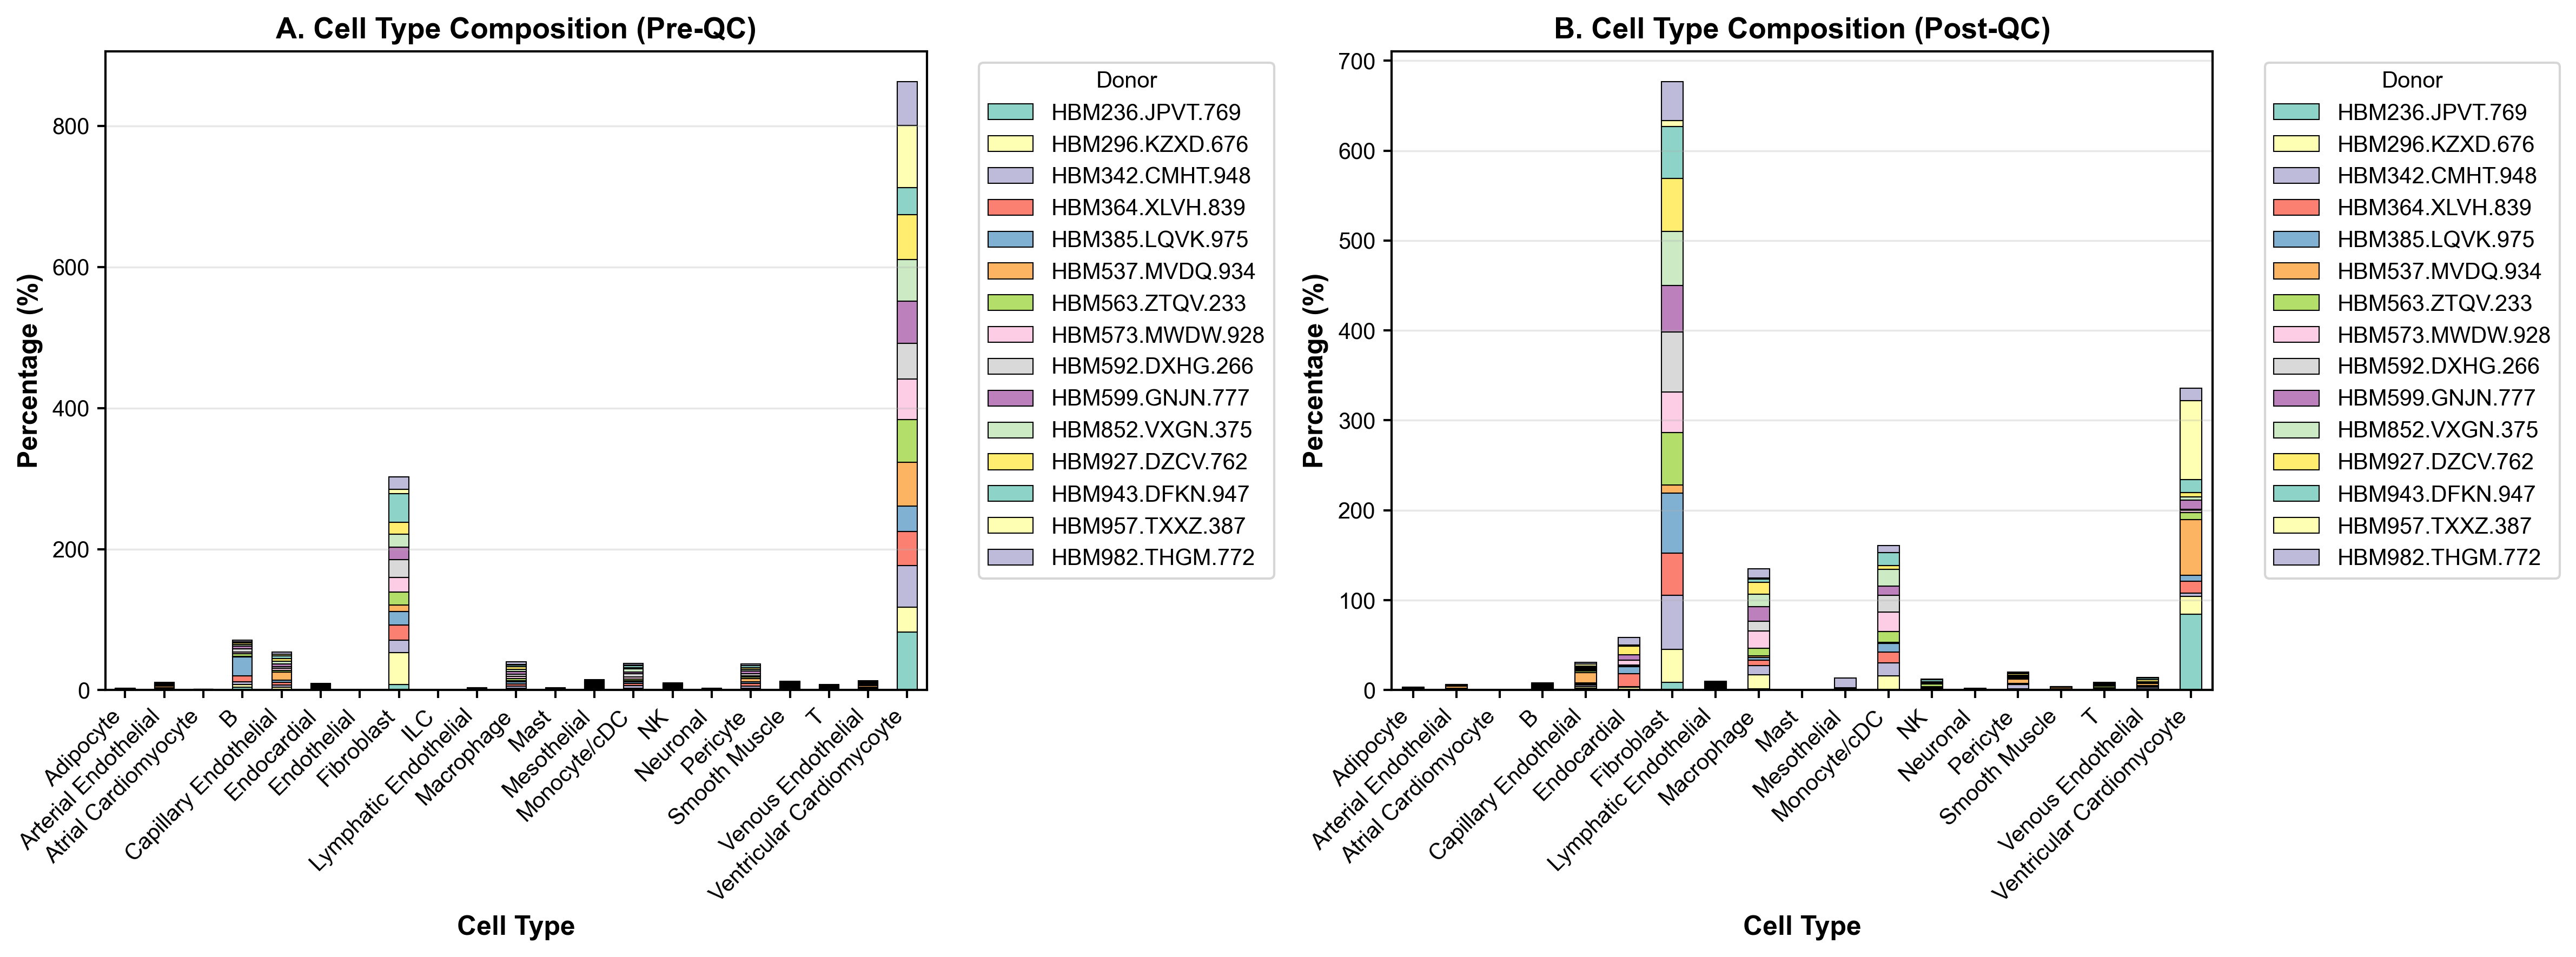

In [15]:
# Check if cell type annotations exist
if "azimuth_label" in adata.obs.columns or "azimuth_label" in adata.obs.columns:
    celltype_col = "azimuth_label" if "azimuth_label" in adata.obs.columns else "predicted_label"

    # Calculate proportions before and after QC
    before_props = (
        adata.obs.groupby(["hubmap_id", celltype_col], observed=True).size().unstack(fill_value=0)
    )
    before_props = before_props.div(before_props.sum(axis=1), axis=0) * 100

    after_props = (
        adata_filtered.obs.groupby(["hubmap_id", celltype_col], observed=True)
        .size()
        .unstack(fill_value=0)
    )
    after_props = after_props.div(after_props.sum(axis=1), axis=0) * 100

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Color palette for cell types
    cell_types = before_props.columns
    colors = sns.color_palette("Set3", n_colors=len(cell_types))

    # Pre-QC composition
    before_props.T.plot(
        kind="bar", stacked=True, ax=ax1, color=colors, edgecolor="black", linewidth=0.5
    )
    ax1.set_xlabel("Cell Type", fontsize=12, fontweight="bold")
    ax1.set_ylabel("Percentage (%)", fontsize=12, fontweight="bold")
    ax1.set_title("A. Cell Type Composition (Pre-QC)", fontsize=13, fontweight="bold")
    ax1.legend(title="Donor", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
    ax1.grid(axis="y", alpha=0.3)

    # Post-QC composition
    after_props.T.plot(
        kind="bar", stacked=True, ax=ax2, color=colors, edgecolor="black", linewidth=0.5
    )
    ax2.set_xlabel("Cell Type", fontsize=12, fontweight="bold")
    ax2.set_ylabel("Percentage (%)", fontsize=12, fontweight="bold")
    ax2.set_title("B. Cell Type Composition (Post-QC)", fontsize=13, fontweight="bold")
    ax2.legend(title="Donor", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
    ax2.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.savefig(figures_dir / "S4_celltype_composition_shift.png", bbox_inches="tight")
    plt.savefig(figures_dir / "S4_celltype_composition_shift.pdf", bbox_inches="tight")
    print("✓ Figure S4 saved: Cell type composition shift")
    plt.show()
else:
    print("⚠ Cell type annotations not found in dataset")
    print("  Skipping Figure S4 - can be generated after clustering/annotation")

### Figure S5: Mitochondrial Gene Expression Signature

**Purpose**: Deep dive into mitochondrial content patterns.

**Panel A** (Violin plots): MT% distribution per donor (post-QC)
- Shows residual variation in mitochondrial content
- Red dashed line = QC threshold
- All violins should be entirely below threshold

**Panel B** (Heatmap): Top 15 MT genes across sampled cells
- Shows which specific MT genes contribute to high MT%
- Cells grouped by donor (visual batch effect check)
- Color intensity = log-normalized expression

**Top MT genes listed**: Typically includes:
- MT-CO1, MT-CO2, MT-CO3 (cytochrome c oxidase subunits)
- MT-ND1, MT-ND2, MT-ND4 (NADH dehydrogenase)
- MT-CYB (cytochrome b)
- MT-ATP6, MT-ATP8 (ATP synthase)

**Interpretation**: Uniform patterns across donors suggest mitochondrial content is biological, not technical.

Top 15 mitochondrial genes by mean expression:
  • MT-RNR2
  • MT-RNR1
  • MT-TY
  • MT-TE


/var/folders/g4/m4yltzqj0c79mflv15hj0b3w0000gn/T/ipykernel_82825/2705766793.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mt_module_scores = adata_filtered.obs.groupby("hubmap_id")["pct_counts_mt"].apply(list)



✓ Figure S5 saved: Mitochondrial gene expression signature


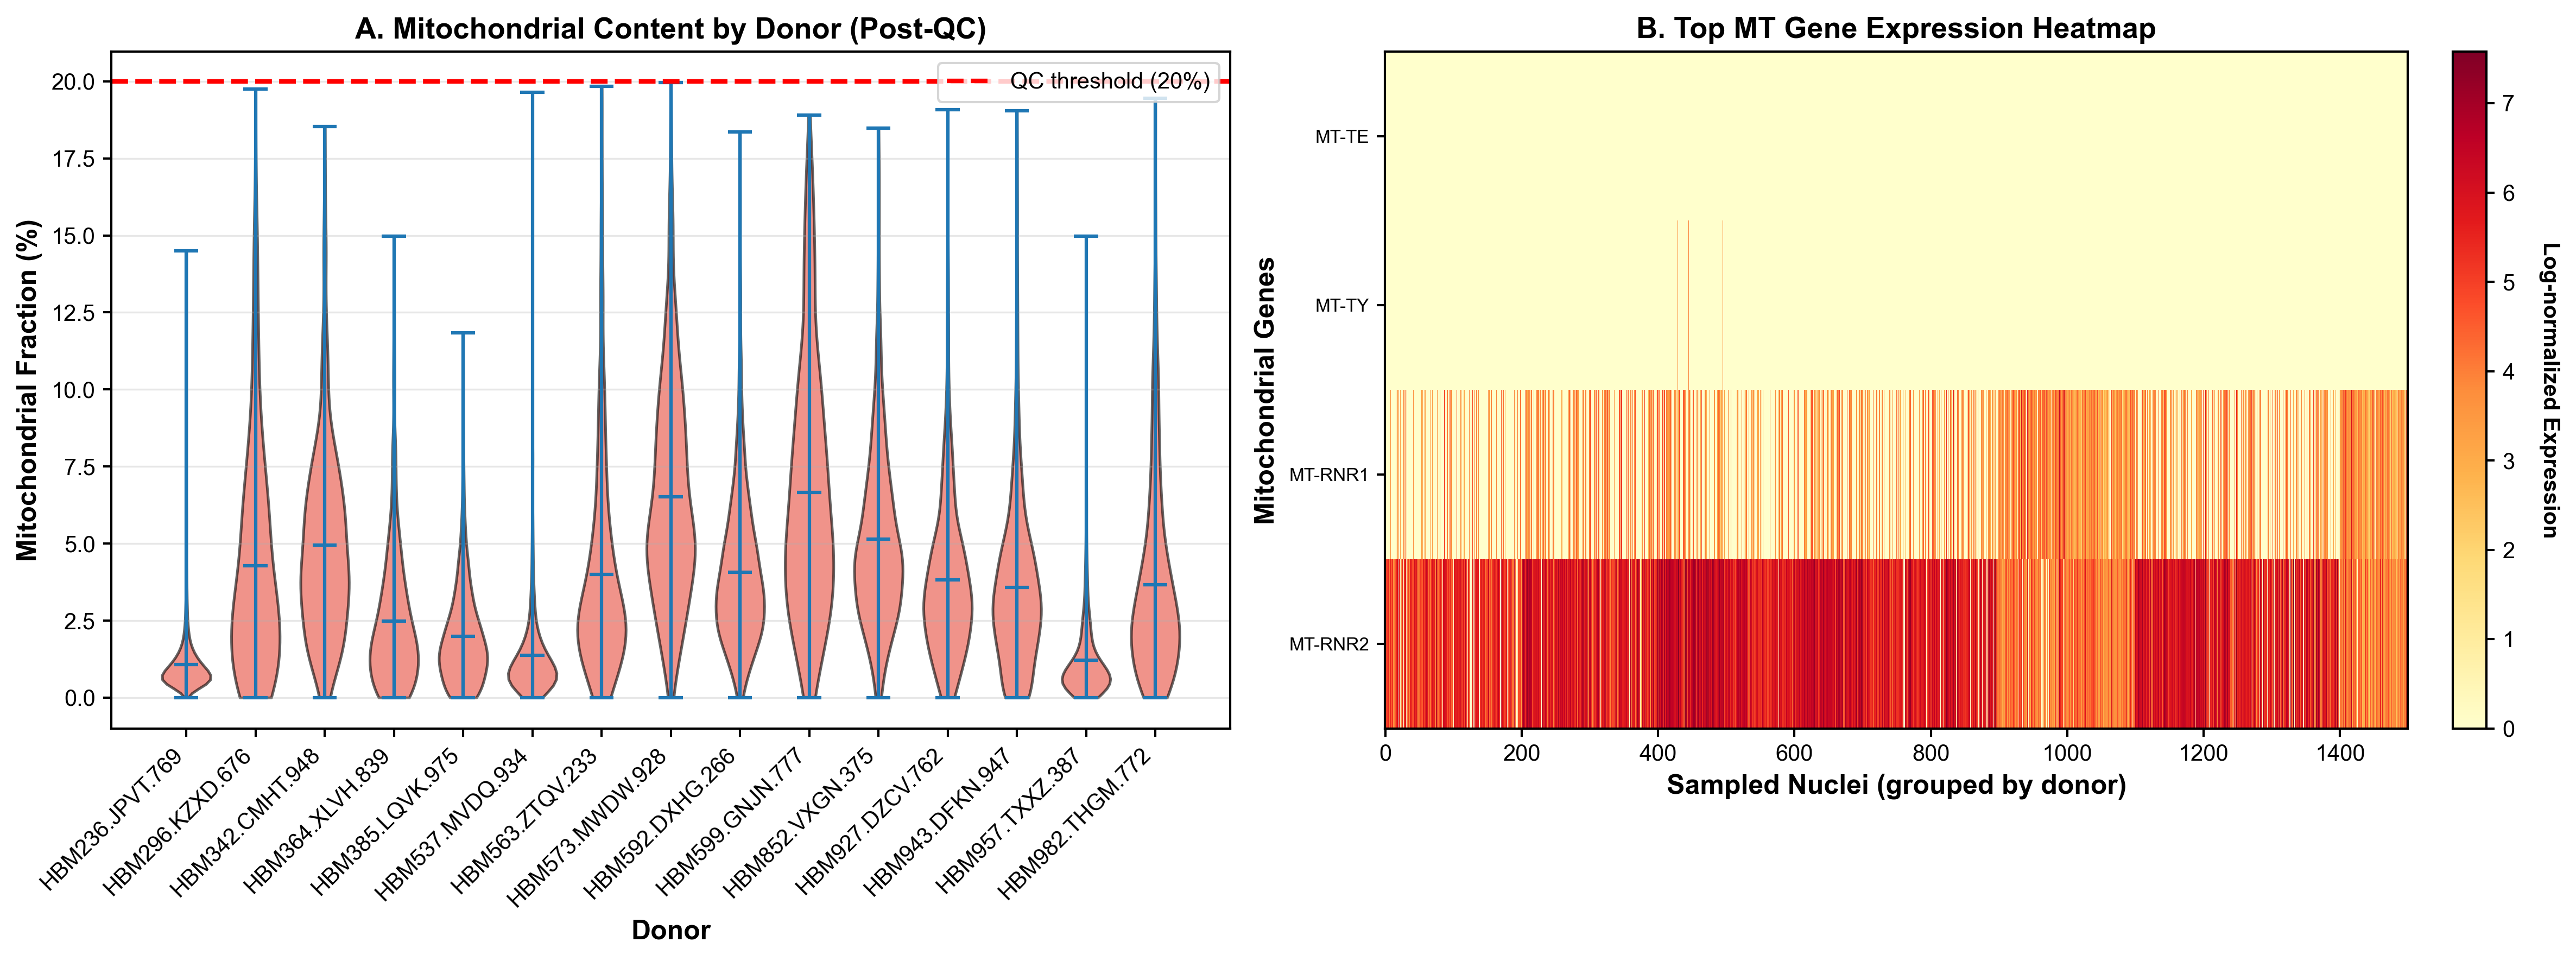

In [16]:
# Identify top mitochondrial genes
mt_genes = adata_filtered.var_names[adata_filtered.var["mt"]]
mt_gene_expr = (
    adata_filtered[:, mt_genes].X.toarray()
    if hasattr(adata_filtered.X, "toarray")
    else adata_filtered[:, mt_genes].X
)
mt_gene_means = mt_gene_expr.mean(axis=0)

# Select top 15 most highly expressed MT genes
top_mt_genes = mt_genes[np.argsort(mt_gene_means)[-15:]]
top_mt_genes_symbols = adata_filtered.var.loc[top_mt_genes, "hugo_symbol"].values

print(f"Top 15 mitochondrial genes by mean expression:")
for gene in top_mt_genes_symbols[::-1]:
    print(f"  • {gene}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Mitochondrial module score distribution by donor
mt_module_scores = adata_filtered.obs.groupby("hubmap_id")["pct_counts_mt"].apply(list)

positions = range(len(mt_module_scores))
violin_parts = ax1.violinplot(
    [scores for scores in mt_module_scores.values],
    positions=positions,
    widths=0.7,
    showmeans=True,
    showextrema=True,
)

# Color violins
for pc in violin_parts["bodies"]:
    pc.set_facecolor("#e74c3c")
    pc.set_alpha(0.6)
    pc.set_edgecolor("black")
    pc.set_linewidth(1.2)

ax1.set_xlabel("Donor", fontsize=12, fontweight="bold")
ax1.set_ylabel("Mitochondrial Fraction (%)", fontsize=12, fontweight="bold")
ax1.set_title(
    "A. Mitochondrial Content by Donor (Post-QC)", fontsize=13, fontweight="bold"
)
ax1.set_xticks(positions)
ax1.set_xticklabels(mt_module_scores.index, rotation=45, ha="right")
ax1.axhline(
    y=MAX_MT_PCT,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"QC threshold ({MAX_MT_PCT}%)",
)
ax1.legend(frameon=True)
ax1.grid(axis="y", alpha=0.3)

# Panel B: Heatmap of top MT genes across donors
# Sample cells per donor for visualization
n_cells_per_donor = 100
sampled_cells = []
for donor in adata_filtered.obs["hubmap_id"].unique():
    donor_cells = adata_filtered.obs[adata_filtered.obs["hubmap_id"] == donor].index
    n_sample = min(n_cells_per_donor, len(donor_cells))
    sampled = np.random.choice(donor_cells, n_sample, replace=False)
    sampled_cells.extend(sampled)

# Extract expression data
expr_data = adata_filtered[sampled_cells, top_mt_genes].X
if hasattr(expr_data, "toarray"):
    expr_data = expr_data.toarray()

# Create heatmap
donor_labels = adata_filtered[sampled_cells].obs["hubmap_id"].values
im = ax2.imshow(expr_data.T, aspect="auto", cmap="YlOrRd", interpolation="nearest")

ax2.set_xlabel("Sampled Nuclei (grouped by donor)", fontsize=12, fontweight="bold")
ax2.set_ylabel("Mitochondrial Genes", fontsize=12, fontweight="bold")
ax2.set_title("B. Top MT Gene Expression Heatmap", fontsize=13, fontweight="bold")
ax2.set_yticks(range(len(top_mt_genes_symbols)))
ax2.set_yticklabels(top_mt_genes_symbols, fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label(
    "Log-normalized Expression", rotation=270, labelpad=20, fontweight="bold"
)

plt.tight_layout()
plt.savefig(figures_dir / "S5_mitochondrial_signature.png", bbox_inches="tight")
plt.savefig(figures_dir / "S5_mitochondrial_signature.pdf", bbox_inches="tight")
print("\n✓ Figure S5 saved: Mitochondrial gene expression signature")
plt.show()